# Descripci√≥n

La compa√±√≠a de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que eval√∫es esa posibilidad.
- Paso 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudar√° a los agentes de la compa√±√≠a con el marketing.
- Paso 2: predecir la probabilidad de que un nuevo cliente reciba una prestaci√≥n del seguro. ¬øPuede un modelo de predictivo funcionar mejor que un modelo dummy?
- Paso 3: predecir el n√∫mero de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresi√≥n lineal.
- Paso 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformaci√≥n de datos que dificulte la recuperaci√≥n de la informaci√≥n personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscaci√≥n de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploraci√≥n de datos

## Inicializaci√≥n

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisi√≥n b√°sica para comprobar que no hay problemas obvios.

In [ ]:
df = pd.read_csv('data/insurance_us.csv')

Renombramos las columnas para que el c√≥digo se vea m√°s coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
3562       1  48.0  63400.0               1                   1
1873       0  22.0  44200.0               1                   0
570        1  32.0  39000.0               4                   0
302        0  29.0  42500.0               1                   0
1631       1  30.0  33500.0               1                   0
4240       0  27.0  37100.0               1                   0
1308       1  32.0  63300.0               1                   0
3441       1  23.0  13500.0               1                   0
296        1  26.0  40600.0               4                   0
1998       1  38.0  42200.0               2                   0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df['age'] = df['age'].astype('int')

In [8]:
# comprueba que la conversi√≥n se haya realizado con √©xito
df['age'].dtype

dtype('int64')

In [9]:
# ahora echa un vistazo a las estad√≠sticas descriptivas de los datos.# ¬øSe ve todo bien?
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

Se observa que los datos en la tabla est√°n en distintas unidades de medida, ya que cada columna representa par√°metros diferentes:

**gender**: Es una columna categ√≥rica codificada con valores de 0 y 1 para que el modelo pueda procesarla. La proporci√≥n de cada categor√≠a podr√≠a influir en los resultados; el valor medio est√° cercano a 0.5, lo que indica una distribuci√≥n bastante equilibrada entre ambas categor√≠as.

**age**: Representa la edad de los clientes en a√±os, en un rango de 18 a 65. Esto es l√≥gico, dado que abarca el rango laboral promedio de una persona. El 75% de los clientes tienen entre 18 y 37 a√±os, lo cual indica una mayor presencia de adultos j√≥venes.

**income**: Representa los ingresos de los clientes. Esta columna tiene valores mucho mayores que las dem√°s, con un rango de 5,300 a 79,000 y un promedio de 39,916. Ser√° importante analizar si este promedio est√° influido por valores at√≠picos, ya que la mayor√≠a de los clientes (75%) tiene ingresos por debajo de 46,600. La gran magnitud de esta columna en comparaci√≥n con las otras podr√≠a generar un peso desproporcionado al entrenar el modelo, lo cual sugiere la necesidad de escalarla.

**family_members**: Indica el n√∫mero de familiares de cada cliente asegurado. La escala de esta columna parece alinearse bien con otras variables num√©ricas y no deber√≠a presentar problemas significativos en el an√°lisis.

**insurance_benefits**: Representa los beneficios de seguro recibidos por cada cliente. La mayor√≠a de los valores en esta columna son cero, lo que sugiere que muchos clientes no han hecho uso de sus beneficios. Este sesgo hacia cero es relevante y puede requerir un tratamiento especial durante el entrenamiento del modelo.

## An√°lisis exploratorio de datos

Vamos a comprobar r√°pidamente si existen determinados grupos de clientes observando el gr√°fico de pares.

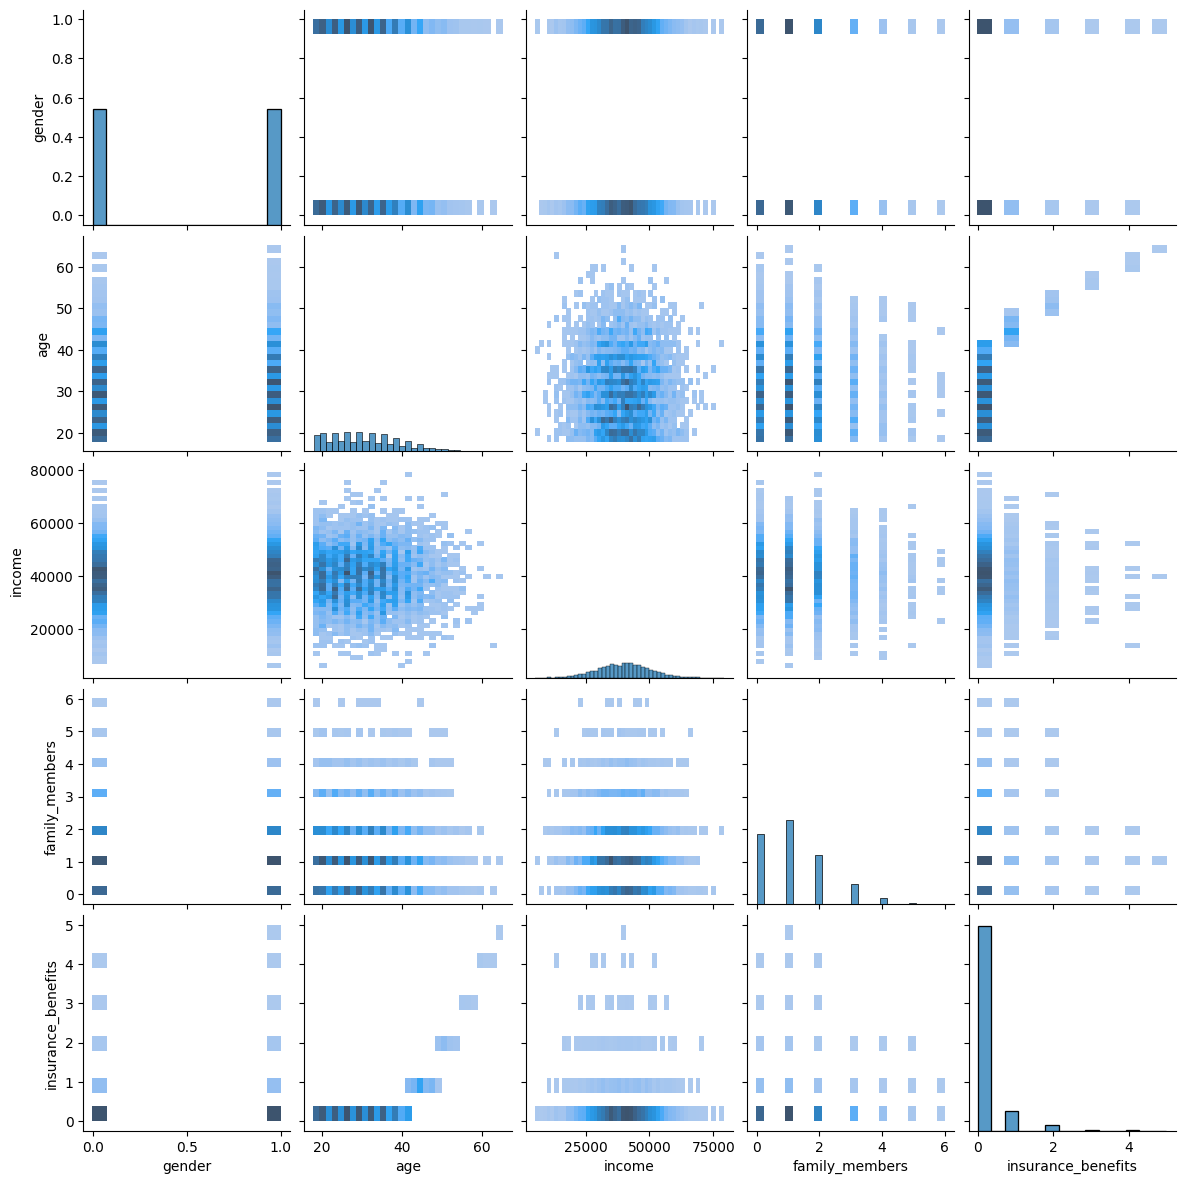

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (cl√∫steres) ya que es dif√≠cil combinar diversas variables simult√°neamente (para analizar distribuciones multivariadas). Ah√≠ es donde LA y ML pueden ser bastante √∫tiles.

# Paso 1: Clientes similares

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos m√°s cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar  
    :param n: n√∫mero de objetos para los que se buscan los vecinos m√°s cercanos   
    :param k: n√∫mero de vecinos m√°s cercanos a devolver
    :param m√©trica: nombre de la m√©trica de distancia    """
 
    # Instanciar el modelo de vecinos m√°s cercanos
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    
    # Ajustar el modelo a las caracter√≠sticas del DataFrame
    nbrs.fit(df[feature_names])

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [ ]:
# Escalar datos
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())
df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
1947     0.0  0.415385  0.437975        0.166667                   0
3087     0.0  0.476923  0.625316        0.166667                   0
4601     1.0  0.384615  0.341772        0.333333                   0
3296     0.0  0.415385  0.631646        0.166667                   0
4879     1.0  0.323077  0.482278        0.000000                   0

Ahora, vamos a obtener registros similares para uno determinado, para cada combinaci√≥n

In [15]:
result_no_scaled = get_knn(df, n=0, k=5, metric='euclidean')
print("Distancia Euclidiana Datos NO escalados:")
display(result_no_scaled)

Distancia Euclidiana Datos NO escalados:


gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625

In [16]:
result_no_scaled = get_knn(df, n=0, k=5, metric='manhattan')
print("Distancia Manhattan Datos NO escalados:")
display(result_no_scaled)

Distancia Manhattan Datos NO escalados:


gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0

In [17]:
# Ejemplo: Distancia Euclidiana, datos escalados
result_scaled = get_knn(df_scaled, n=0, k=5, metric='euclidean')
print("Distancia Euclidiana Datos escalados:")
display(result_scaled)

Distancia Euclidiana Datos escalados:


gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550

In [18]:
result_scaled = get_knn(df_scaled, n=0, k=5, metric='manhattan')
print("Distancia Manhattan Datos escalados:")
display(result_scaled)

Distancia Manhattan Datos escalados:


gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646

Respuestas a las preguntas

**¬øEl hecho de que los datos no est√©n escalados afecta al algoritmo kNN? Si es as√≠, ¬øc√≥mo se manifiesta?** 

El escalado de los datos tiene un impacto significativo en el desempe√±o del algoritmo kNN porque las m√©tricas de distancia, como la Euclidiana y la Manhattan, son sensibles a las magnitudes de las caracter√≠sticas. En el caso de datos no escalados, las caracter√≠sticas con valores m√°s grandes, como el income, dominan las distancias calculadas, mientras que caracter√≠sticas con valores m√°s peque√±os, como gender, tienen poca influencia en la determinaci√≥n de los vecinos m√°s cercanos.

Al escalar los datos, cada caracter√≠stica contribuye de manera proporcional al c√°lculo de la distancia, lo que mejora la identificaci√≥n de similitudes reales entre los datos. Esto es crucial en tareas de clasificaci√≥n, ya que permite agrupar objetos de manera m√°s precisa en funci√≥n de todas las caracter√≠sticas relevantes.

**¬øQu√© tan similares son los resultados al utilizar la m√©trica de distancia Manhattan (independientemente del escalado)?** 

Los resultados obtenidos al usar la m√©trica de distancia Manhattan y Euclidiana son bastante similares. En los datos no escalados, la diferencia es de 1 o 2 puntos, mientras que en los datos escalados, esta diferencia es de aproximadamente 0.01. Estas diferencias pueden considerarse significativas dependiendo del contexto del modelo y la m√©trica utilizada.

La distancia Euclidiana enfatiza diferencias grandes debido a su c√°lculo cuadr√°tico, lo que puede ser beneficioso cuando las caracter√≠sticas tienen distribuciones m√°s homog√©neas o cuando se desea resaltar grandes discrepancias. Sin embargo, tambi√©n es m√°s sensible a problemas de escalado, ya que las caracter√≠sticas con valores m√°s grandes tendr√°n mayor influencia.

Por otro lado, la distancia Manhattan es m√°s robusta frente a valores extremos, ya que calcula la suma de diferencias absolutas. Esto la hace adecuada para datos con caracter√≠sticas heterog√©neas o donde se desea evitar el impacto desproporcionado de valores extremos.

En este caso particular, al usar datos escalados, la distancia Euclidiana parece ofrecer una mejor precisi√≥n al identificar similitudes m√°s sutiles, posiblemente debido a c√≥mo destaca patrones m√°s peque√±os. Sin embargo, ambas m√©tricas presentan resultados muy cercanos, lo que indica que la elecci√≥n depender√° del problema espec√≠fico y la naturaleza de los datos.

# Paso 2. ¬øEs probable que el cliente reciba una prestaci√≥n del seguro?

En t√©rminos de machine learning podemos considerarlo como una tarea de clasificaci√≥n binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, eval√∫a si el enfoque de clasificaci√≥n kNN puede funcionar mejor que el modelo dummy.

- Construir un clasificador basado en KNN y mide su calidad con la m√©trica F1 para k=1...10 tanto para los datos originales como para los escalados. Ser√≠a interesante observar c√≥mo k puede influir en la m√©trica de evaluaci√≥n y si el escalado de los datos provoca alguna diferencia. 

- Construir un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Deber√≠a devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestaci√≥n del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestaci√≥n del seguro puede definirse como
$$
P\{\text{prestaci√≥n de seguro recibida}\}=\frac{\text{n√∫mero de clientes que han recibido alguna prestaci√≥n de seguro}}{\text{n√∫mero total de clientes}}.
$$

Divir todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30.

In [ ]:
# Clasifica los datos para definir una columna objetivo
def set_target_split(data):
        """
    Crea la columna 'insurance_benefits_received' basada en si insurance_benefits > 0.
    Divide el DataFrame en conjuntos de entrenamiento y prueba.
    Devuelve: train_X, test_X, train_y, test_y
    """
        # Clasifica los datos
        data['insurance_benefits_received'] = 0
        data.loc[data['insurance_benefits'] > 0,'insurance_benefits_received']=1
        # Divide los datos 
        train_df, test_df = train_test_split(data, test_size=0.3, random_state=1234)
        train_X, test_X =  train_df[feature_names], test_df[feature_names]
        train_y, test_y = train_df['insurance_benefits_received'], test_df['insurance_benefits_received']
        return train_X, test_X, train_y, test_y

In [ ]:
train_X, test_X, train_y, test_y = set_target_split(df)
sc_train_X, sc_test_X, sc_train_y, sc_test_y = set_target_split(df_scaled)

In [21]:
def eval_classifier(y_true, y_pred):
    """
    Eval√∫a el modelo con m√©tricas de F1 y matriz de confusi√≥n.
    """
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusi√≥n')
    print(cm)

In [22]:
# Crear y entrenar modelo de clasificacion KNeighbors
def create_knn_model(train_X, test_X, train_y, test_y):
    """
    Entrena y eval√∫a el modelo KNN para k=1...10.
    """
    f1_scores = [] # Guardar los F1 para graficar m√°s adelante
    for k in range(1,11):
        model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        model.fit(train_X, train_y)
        predict_y = model.predict(test_X)
    
        print(f"Resultados para ùëò={k}:")
        eval_classifier(test_y, predict_y)  # Eval√∫a el modelo
        print("-" * 30)  # Separador para claridad
        # Guardar F1 para an√°lisis posterior
        f1_scores.append(sklearn.metrics.f1_score(test_y, predict_y))
    return f1_scores

In [23]:
# comprueba el desequilibrio de clases con value_counts()
train_y.value_counts()

0    3109
1     391
Name: insurance_benefits_received, dtype: int64

Existe un evidente desequilibrio entre los datos, s√≥lo alrededor del 10% de estos corresponden a clientes que cobraron alg√∫n seguro

In [24]:
# Crear modelos para datos no escalados y escalados
print('Modelos con datos NO escalados:\n' ,('=')*30)
f1_no_scaling = create_knn_model(train_X, test_X, train_y, test_y)

Modelos con datos NO escalados:
Resultados para ùëò=1:
F1: 0.63
Matriz de confusi√≥n
[[0.85933333 0.02533333]
 [0.05066667 0.06466667]]
------------------------------
Resultados para ùëò=2:
F1: 0.38
Matriz de confusi√≥n
[[0.87666667 0.008     ]
 [0.08666667 0.02866667]]
------------------------------
Resultados para ùëò=3:
F1: 0.41
Matriz de confusi√≥n
[[0.87333333 0.01133333]
 [0.08266667 0.03266667]]
------------------------------
Resultados para ùëò=4:
F1: 0.21
Matriz de confusi√≥n
[[0.882      0.00266667]
 [0.10133333 0.014     ]]
------------------------------
Resultados para ùëò=5:
F1: 0.21
Matriz de confusi√≥n
[[0.87933333 0.00533333]
 [0.10133333 0.014     ]]
------------------------------
Resultados para ùëò=6:
F1: 0.11
Matriz de confusi√≥n
[[0.88333333 0.00133333]
 [0.10866667 0.00666667]]
------------------------------
Resultados para ùëò=7:
F1: 0.11
Matriz de confusi√≥n
[[0.88133333 0.00333333]
 [0.10866667 0.00666667]]
------------------------------
Resultados para 

El modelo muestra un sesgo hacia la clase mayoritaria (0) debido al desequilibrio de los datos. Esto se refleja en las matrices de confusi√≥n, donde la mayor√≠a de las predicciones caen en la clase 0, independientemente de los valores reales.

A medida que $k$ aumenta, el modelo considera m√°s vecinos al hacer la predicci√≥n. Como los datos no est√°n escalados, las distancias entre puntos no reflejan adecuadamente las relaciones reales, lo que perjudica la capacidad del modelo para identificar correctamente la clase minoritaria (1). Esto aumenta los falsos positivos y reduce los verdaderos positivos, como bien observaste.

El F1-Score disminuye significativamente con valores mayores de $k$, lo que confirma que el modelo tiene cada vez m√°s dificultades para equilibrar precisi√≥n y sensibilidad al identificar la clase 1.

In [25]:
print('Modelos con datos escalados:\n' ,('=')*30)
f1_scaling = create_knn_model(sc_train_X, sc_test_X, sc_train_y, sc_test_y)

Modelos con datos escalados:
Resultados para ùëò=1:
F1: 0.95
Matriz de confusi√≥n
[[0.882      0.00266667]
 [0.008      0.10733333]]
------------------------------
Resultados para ùëò=2:
F1: 0.92
Matriz de confusi√≥n
[[0.88466667 0.        ]
 [0.018      0.09733333]]
------------------------------
Resultados para ùëò=3:
F1: 0.95
Matriz de confusi√≥n
[[0.88266667 0.002     ]
 [0.00866667 0.10666667]]
------------------------------
Resultados para ùëò=4:
F1: 0.93
Matriz de confusi√≥n
[[8.84000000e-01 6.66666667e-04]
 [1.46666667e-02 1.00666667e-01]]
------------------------------
Resultados para ùëò=5:
F1: 0.93
Matriz de confusi√≥n
[[0.88133333 0.00333333]
 [0.01133333 0.104     ]]
------------------------------
Resultados para ùëò=6:
F1: 0.93
Matriz de confusi√≥n
[[8.84000000e-01 6.66666667e-04]
 [1.53333333e-02 1.00000000e-01]]
------------------------------
Resultados para ùëò=7:
F1: 0.94
Matriz de confusi√≥n
[[0.88066667 0.004     ]
 [0.01       0.10533333]]
------------------

El modelo KNN muestra una mejora notable al trabajar con datos escalados. Esto se refleja en un incremento significativo en el recall, permitiendo detectar m√°s verdaderos positivos sin sacrificar precisi√≥n, y un F1-Score alto y consistente para diferentes valores de $k$. A diferencia de enfoques como bosques aleatorios que podr√≠an requerir balancear las clases, KNN escalado logra un buen desempe√±o directamente, gracias a su dependencia en distancias bien ajustadas. Adem√°s, su estabilidad frente a cambios en 
$k$ demuestra una robustez que lo hace adecuado para este problema.

El gr√°fico a continuacion muestra el rendimiento de los modelos KNN entrenados con los datos No escalados y con los datos escalados.

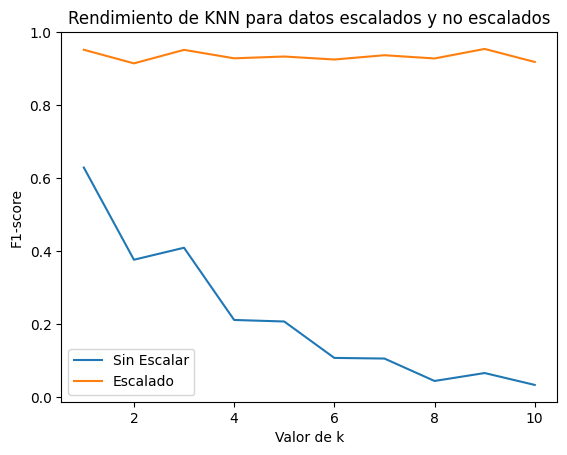

In [26]:
# Opcional: Graficar los F1-scores para cada valor de k
import matplotlib.pyplot as plt

plt.plot(range(1, 11), f1_no_scaling, label="Sin Escalar")
plt.plot(range(1, 11), f1_scaling, label="Escalado")
plt.xlabel("Valor de k")
plt.ylabel("F1-score")
plt.title("Rendimiento de KNN para datos escalados y no escalados")
plt.legend()
plt.show()

In [27]:
# generar la salida de un modelo aleatorio
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusi√≥n
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusi√≥n
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusi√≥n
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusi√≥n
[[0.     0.8872]
 [0.     0.1128]]



***Modelo dummy con probabilidad 0:***
Este caso simplemente predice que todos los casos pertenecen a la clase negativa (0). Como esperabas, tiene precisi√≥n perfecta porque nunca predice falsos positivos, pero su recall es 0, lo que lleva a un F1-score de 0. Este modelo no es √∫til en la pr√°ctica.

***Modelo dummy con probabilidad real de los datos (0.11):***
Aqu√≠, el modelo dummy predice la clase positiva (1) en la proporci√≥n observada en los datos reales. Esto hace que el recall aumente, ya que predice correctamente algunos de los casos positivos, pero al costo de reducir la precisi√≥n (por falsos positivos). El F1-score mejora en comparaci√≥n con el modelo con probabilidad 0.

***Modelo dummy con probabilidad 0.5:***
Este modelo divide sus predicciones entre clases positivas y negativas casi uniformemente, lo que genera un gran aumento de falsos positivos y falsos negativos. Aunque mejora ligeramente el recall, la precisi√≥n sufre dr√°sticamente, y el F1-score apenas llega a 0.2.

***Modelo dummy con probabilidad 1:***
Este caso predice que todos los casos pertenecen a la clase positiva (1). Tiene el recall m√°s alto posible (predice todos los positivos correctamente), pero su precisi√≥n es nula porque predice positivos incluso donde no los hay, dando nuevamente un F1-score muy bajo.

***Conclusi√≥n sobre KNN vs. dummy:***
El modelo KNN claramente supera al modelo dummy en todas las probabilidades evaluadas. Esto confirma que el KNN est√° aprendiendo patrones significativos de los datos, mientras que el modelo dummy solo genera predicciones basadas en probabilidades sin interpretar patrones.


# Paso 3. Regresi√≥n (con regresi√≥n lineal)

Con `insurance_benefits` como objetivo, se evaluar√° cu√°l ser√≠a la RECM de un modelo de regresi√≥n lineal.

Construir una implementacion propia de Regresion Lineal. Para ello, hay que considerar c√≥mo est√° formulada la soluci√≥n de la tarea de regresi√≥n lineal en t√©rminos de LA. Comprueba la RECM tanto para los datos originales como para los escalados.

¬øExiste alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de caracter√≠sticas; cada fila es un caso, cada columna es una caracter√≠stica, la primera columna est√° formada por unidades
- $y$ ‚Äî objetivo (un vector)
- $\hat{y}$ ‚Äî objetivo estimado (un vector)
- $w$ ‚Äî vector de pesos
La tarea de regresi√≥n lineal en el lenguaje de las matrices puede formularse as√≠:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$  que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una soluci√≥n anal√≠tica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La f√≥rmula anterior puede servir para encontrar los pesos $w$ y estos √∫ltimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30. Utiliza la m√©trica RECM para evaluar el modelo.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        """crea el atributo weighs para la clase MyLinearRegression"""
        self.weights = None
    
    def fit(self, X, y):
        """Entrena el modelo"""
        #a√±adir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        """Predice los cuantos clientes cobraran seguros"""
        # a√±adir las unidades
        X2 = np.append(np.ones([len(X),1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [30]:

def eval_regressor(y_true, y_pred):
    """Evalua modelos de Regresion Lineal"""
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')   
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')    
    return rmse, r2_score

In [31]:
def create_train_lr(data):
    """
    Separa los datos del dataframe en caracteristicas y objetivos
    Divide los datos para entrenamiento y prueva con proporcion 70:30
    Crea y entrena un modelo de Regresion Lineal con la clase MyLinearRegression
    Imprime el peso de cada una de las caracteristicas para el modelo
    Evalua El RMSE y R2 del modelo"""
    
    X = data[['age', 'gender', 'income', 'family_members']].to_numpy()
    y = data['insurance_benefits'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

    lr = MyLinearRegression()

    lr.fit(X_train, y_train)
    
    # Imprime con tabulaci√≥n 
    print(f"{'Feature':<15} {'Weight':<15}")  # Encabezados con ancho fijo
    print("-" * 30)
    for name, weight in zip(feature_names, lr.weights):
        print(f"{name:<15} :{weight:<15.6e}")  # Cada columna alineada
    print("=" * 30)
    y_test_pred = lr.predict(X_test)
    return eval_regressor(y_test, y_test_pred)

In [32]:
lr_model_normal_data = create_train_lr(df)

Feature         Weight         
------------------------------
gender          :-9.435390e-01  
age             :3.574955e-02   
income          :1.642727e-02   
family_members  :-2.607437e-07  
RMSE: 0.34
R2: 0.43


In [33]:
lr_model_scaled_data = create_train_lr(df_scaled)

Feature         Weight         
------------------------------
gender          :-9.435390e-01  
age             :2.323721e+00   
income          :1.642727e-02   
family_members  :-2.059875e-02  
RMSE: 0.34
R2: 0.43


A pesar de las diferencias en el vector de pesos, los valores de ***RMSE*** y ***R¬≤*** son iguales para los modelos de regresi√≥n lineal con datos escalados y no escalados. Esto confirma que el escalado de las caracter√≠sticas no afecta la calidad del modelo en t√©rminos de error y capacidad explicativa, pero s√≠ cambia la magnitud de los coeficientes.

# Paso 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las caracter√≠sticas num√©ricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba c√≥mo quedar√°n los valores de las caracter√≠sticas despu√©s de la transformaci√≥n. Por cierto, la propiedad de invertibilidad es importante aqu√≠, as√≠ que aseg√∫rate de que $P$ sea realmente invertible.

Puedes revisar la lecci√≥n 'Matrices y operaciones matriciales -> Multiplicaci√≥n de matrices' para recordar la regla de multiplicaci√≥n de matrices y su implementaci√≥n con NumPy.

In [34]:
# Selecciona la info
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [36]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [37]:
P_inv = np.linalg.inv(P)

La matriz es inversible ya que no se gener√≥ ning√∫n error

In [38]:
X_= X @ P
print(X_)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


**¬øPuedes adivinar la edad o los ingresos de los clientes despu√©s de la transformaci√≥n?**

No parece f√°cil adivinar cualquier informaci√≥n con esta transformacion, ya que lo unico que mantiene de la matriz original es la cantidad de columnas

**¬øPuedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a trav√©s de los c√°lculos moviendo $P$ del lado derecho de la f√≥rmula anterior al izquierdo. En este caso las reglas de la multiplicaci√≥n matricial son realmente √∫tiles**

In [39]:
X_recovered = X_ @ P_inv 
# Comparar X_recovered con X original
print("¬øRecuperaci√≥n exitosa?", np.allclose(X, X_recovered))

¬øRecuperaci√≥n exitosa? True


Muestra los tres casos para algunos clientes
- Datos originales
- El que est√° transformado
- El que est√° invertido (recuperado)

In [40]:
# Datos Originaales
print(X[:5])

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]


In [41]:
# Datos Ofuscados
print(X_[:5])

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]


In [42]:
# Datos Recuperados
print( X_recovered[:5])

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


**Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¬øCu√°l podr√≠a ser la raz√≥n de ello?**

La raz√≥n por la que algunos valores recuperados no coinciden exactamente con los originales es que los errores de redondeo y precisi√≥n en los c√°lculos con matrices son inevitables. Aun as√≠, estos errores son generalmente muy peque√±os y no afectan significativamente el an√°lisis o los resultados finales.

## Prueba de que la ofuscaci√≥n de datos puede funcionar con regresi√≥n lineal

En este proyecto la tarea de regresi√≥n se ha resuelto con la regresi√≥n lineal. El siguiente paso es demostrar analiticamente que el m√©todo de ofuscaci√≥n no afectar√° a la regresi√≥n lineal en t√©rminos de valores predichos, es decir, que sus valores seguir√°n siendo los mismos. ¬øLo puedes creer? Pues no hace falta que lo creas, hay que que demostrarlo!

Entonces, los datos est√°n ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¬øC√≥mo se relacionar√≠an $w$ y $w_P$ si simplific√°ramos la f√≥rmula de $w_P$ anterior? 

¬øCu√°les ser√≠an los valores predichos con $w_P$? 

¬øQu√© significa esto para la calidad de la regresi√≥n lineal si esta se mide mediante la RECM?

**Respuesta**

En un modelo de regresi√≥n lineal, la transformaci√≥n de los datos mediante la matriz $P$ no altera los resultados porque conserva las relaciones proporcionales entre las variable. Esto ocurre porque durante los c√°lculos, $P$ se cancela con su inversa.
los valores de $w_p$ predichos seran los mismos que los de $w$ al igual que el RECM

**Prueba anal√≠tica**

La f√≥rmula original para $w$ en la regresi√≥n lineal es:

$w = (X^T X)^{-1} X^T y$

Si ofuscamos los datos multiplic√°ndolos por una matriz $P$ los pesos $w_p$ se calculan como:

$w_P = [(XP)^T XP]^{-1} (XP)^T y$ 

Expandiendo esta f√≥rmula:

$w_p$ = $[(P^T X^T) (XP)]^{-1} (X^T P^T) y $

Usando la propiedad asociativa y la conmutatividad de las transposiciones:

$w_p$ = $[P^T(X^T X)P]^{-1} P^T(X^T y)  $

Aplicamos la propiedad de inversi√≥n de productos de matrices $(AB)^{-1} = B^{-1} A^{-1}$:

$ w_p = P^{-1}(X^T X)^{-1}(P^T)^{-1} P^T X^T y$

Finalmente, como $ (P^T)^{-1} P^T = I $ (la matriz identidad), se simplifica a:

$ w_p = P^{-1}(X^T X)^{-1} X^T y$

En este paso $P^{-1}$ est√° fuera del c√°lculo interno de los pesos, ya que no depende de $X$ o de $y$. Esto implica que, en esencia, los pesos que determinan la relaci√≥n entre $X$ e $y$ permanecen iguales.

Por lo tanto:
 
 $w_p = P^{-1}w$

La relaci√≥n entre $w$ y $w_p$ muestra que los pesos predichos dependen de la transformaci√≥n por $P^{-1}$
 , pero la calidad de las predicciones no se ve afectada porque la regresi√≥n sigue capturando las mismas relaciones entre las variables.
Los valores predichos se calculan como:

$\hat{y} = Xw$

Con la matriz ofuscada, los valores predichos son:

$\hat{y}p = (XP)wp$

Sustituyendo: 

$\hat{y}p = (XP)(P^{-1}w)= X(PP^{-1}w)= Xw = \hat{y}$

Esto demuestra que los valores predichos $\hat{y}p$ son id√©nticos a los valores predichos originales $\hat{y}$, ya que 
$P$ se cancela con $P^{-1}$

Impacto en la calidad de la regresi√≥n lineal (RECM):

Dado que los valores predichos no cambian, el Error Cuadr√°tico Medio (RECM) no se ve afectado. Esto significa que la ofuscaci√≥n de datos mediante una matriz invertible 
$P$ es completamente transparente para el modelo de regresi√≥n lineal, ya que no altera la precisi√≥n ni la calidad de las predicciones.

## Prueba de regresi√≥n lineal con ofuscaci√≥n de datos

Ahora, probemos que la regresi√≥n lineal pueda funcionar, en t√©rminos computacionales, con la transformaci√≥n de ofuscaci√≥n elegida.
Construir un procedimiento o una clase que ejecute la regresi√≥n lineal opcionalmente con la ofuscaci√≥n.
Ejecutar la regresi√≥n lineal para los datos originales y los ofuscados, comparar los valores predichos y los valores de las m√©tricas RMSE y $R^2$. ¬øHay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de n√∫meros aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- Utiliza $XP$ como la nueva matriz de caracter√≠sticas

In [43]:
# Crea una matriz cuadrada ùëÉ de n√∫meros aleatorios
X = df[feature_names].to_numpy()
rng = np.random.default_rng(seed=123)
P2 = rng.random(size=(X.shape[1], X.shape[1]))

In [44]:
# Comprueba que sea invertible
P2_inv = np.linalg.inv(P2)

In [45]:
# Crear la matriz  ùëãùëÉ 
XO = X @ P2

In [46]:
# Utiliza  ùëãùëÉ como la nueva matriz de caracter√≠sticas
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(XO, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
    
print(f"{'Feature':<15} {'Weight':<15}")  # Encabezados con ancho fijo
print("-" * 30)
for name, weight in zip(feature_names, lr.weights):
    print(f"{name:<15} :{weight:<15.6e}")  # Cada columna alineada
print("=" * 30)
y_test_pred = lr.predict(X_test)
lr_model_ofuscated_data =eval_regressor(y_test, y_test_pred)

Feature         Weight         
------------------------------
gender          :-9.435411e-01  
age             :4.249023e-02   
income          :-6.518928e-02  
family_members  :1.599284e-01   
RMSE: 0.34
R2: 0.43


In [47]:
# Compara los las evaluaciones de los 3 modelos de regresion lineal en este proyecto
models = [lr_model_normal_data, lr_model_scaled_data, lr_model_ofuscated_data]
for model in models: 
    rmse, r2 = model 
    print(f'RMSE: {rmse:.4f}') 
    print(f'R2 Score: {r2:.4f}')
    print("="*30)

RMSE: 0.3436
R2 Score: 0.4305
RMSE: 0.3436
R2 Score: 0.4305
RMSE: 0.3436
R2 Score: 0.4305


# Conclusiones

El modelo K-Nearest Neighbors (KNN) demostr√≥ ser una opci√≥n s√≥lida para tareas de clasificaci√≥n en este proyecto. Este modelo se basa en distancias matem√°ticas entre las caracter√≠sticas de los datos de entrenamiento y los nuevos datos, lo que le otorga confiabilidad al no depender de procesos aleatorios como los √°rboles de decisi√≥n o los bosques aleatorios. Sin embargo, su rendimiento es sensible a la magnitud de las caracter√≠sticas, por lo que se recomienda escalar los datos antes de entrenar un modelo de este tipo.

En cuanto a las m√©tricas de distancia, tanto la distancia Euclidiana como la Manhattan son √∫tiles en diferentes escenarios. La distancia Euclidiana resalta discrepancias m√°s grandes debido a su c√°lculo cuadr√°tico, lo que puede ser ventajoso para datos homog√©neos o distribuciones uniformes. Por otro lado, la distancia Manhattan es m√°s adecuada para datos m√°s dispersos y heterog√©neos, ya que es menos sensible a valores extremos.

Para este proyecto, el uso de la distancia Euclidiana y datos escalados result√≥ ser la configuraci√≥n √≥ptima. El modelo resultante alcanz√≥ un excelente puntaje F1 de 0.95 y mostr√≥ una consistencia notable independientemente del valor de 
$k$ (n√∫mero de vecinos). Esto resalta la robustez del modelo en las condiciones espec√≠ficas del problema abordado.

Adem√°s el modelo prob√≥ funcionar mucho mejor que el modelo dummy.


A diferencia del modelo KNN, que se utiliz√≥ para predecir si un nuevo cliente recibir√≠a beneficios del seguro, el modelo de regresi√≥n lineal, empleado para estimar la cantidad de beneficios que probablemente recibir√°, mostr√≥ una robustez notable. Este modelo no se ve afectado ni por la escala de los datos ni por su ofuscaci√≥n, lo cual es una ventaja significativa. Esta propiedad permite aplicar transformaciones como la encriptaci√≥n u ofuscaci√≥n de los datos, garantizando una mayor seguridad para los clientes sin comprometer la calidad de las predicciones.

A lo largo de este sprint, se destac√≥ la relevancia de comprender y aplicar conceptos fundamentales de matem√°ticas para potenciar las t√©cnicas de Machine Learning. En este caso, la utilidad de los vectores, las matrices y la regresi√≥n lineal fue crucial para desarrollar modelos efectivos y garantizar resultados precisos. Este enfoque interdisciplinario resalta c√≥mo las matem√°ticas sirven como base para resolver problemas complejos y optimizar algoritmos en el √°mbito del aprendizaje autom√°tico.

# Lista de control

- [x]  El c√≥digo no tiene errores
- [x]  Las celdas est√°n ordenadas de acuerdo con la l√≥gica y el orden de ejecuci√≥n
- [x]  **Se ha realizado el paso 1**
    - [x]  Est√° presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se prob√≥ el procedimiento para las cuatro combinaciones propuestas    
    - [x]  Se respondieron las preguntas sobre la escala/distancia
- [x]  **Se ha realizado el paso 2**
    - [x]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n aleatoria para todos los niveles de probabilidad   
    - [x]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n kNN tanto para los datos originales como para los escalados. Se calcul√≥ la m√©trica F1.
- [x]  **Se ha realizado el paso 3**
    - [x]  Se implement√≥ la soluci√≥n de regresi√≥n lineal mediante operaciones matriciales   
    - [x]  Se calcul√≥ la RECM para la soluci√≥n implementada
- [x]  **Se ha realizado el paso 4**
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P   
    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos   
    - [x]  Se proporcion√≥ la prueba anal√≠tica de que la transformaci√≥n no afecta a la RECM   
    - [x]  Se proporcion√≥ la prueba computacional de que la transformaci√≥n no afecta a la RECM
    - [x]  Se han sacado conclusiones

# Ap√©ndices

## Ap√©ndice A: Escribir f√≥rmulas en los cuadernos de Jupyter

Puedes escribir f√≥rmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicaci√≥n de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las f√≥rmulas se ver√°n como las de los libros de texto.

Para incorporar una f√≥rmula a un texto, pon el signo de d√≥lar (\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una f√≥rmula debe estar en el mismo p√°rrafo, pon el doble signo de d√≥lar (\\$\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan f√≥rmulas en sus art√≠culos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en ingl√©s) de dos p√°ginas para aprender a componer las f√≥rmulas m√°s comunes.

## Ap√©ndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al √°lgebra lineal. Aqu√≠ se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba anal√≠tica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicaci√≥n</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposici√≥n de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>